In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
import torch

from ebb.env.luxenv import OBSERVATION_SPACE
from ebb.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-1.06,
        reward_max=+1.06,
        zero_sum=False,
    )

/Users/flynnwang/python_envs/lux-s3-312/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# Load model

In [4]:
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/048021120_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251226_units_run_out_of_energy/043652096_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251227_fix_action_center/029805568_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251227_fix_action_center/038978560_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_small_reward_range/003574656_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_small_reward_range/012532608_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_small_reward_range/014323840_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_use_action_taken/039774592_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_use_action_taken/043380864_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251228_use_action_taken/063213056_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/debug_run_20251231_exploration_reward_no_remapping/008947328_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/run_20250102_use_game_win_loss/001666432_weights.pt"
# checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)

# model_path = "/Users/flynnwang/repo/flynn/runs/mds/run_20250106_shared_unit_layers_v0/043562496_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/mds/run_20250109_game_win_loss_r1/009059840_weights.pt"

model_path = "/Users/flynnwang/repo/flynn/runs/mds/run_20250109_nebula_features_0/004457216_weights.pt"

model = _create_model(OBSERVATION_SPACE, reward_spec=reward_spec, n_blocks=8, hidden_dim=128, base_out_channels=128,
                      embedding_dim=32, kernel_size=5)

checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(checkpoint_state["model_state_dict"])

<All keys matched successfully>

# Model Run

In [5]:
from ebb.torchbeast.core.selfplay import split_env_output_by_player, pair_env_output_for_players

def actor_model_apply(env_output):
  lef_env_out, rig_env_out = split_env_output_by_player(env_output)
  lef_agent_out = actor_model(lef_env_out)
  rig_agent_out = actor_model(rig_env_out)
  return [(lef_env_out, lef_agent_out), (rig_env_out, rig_agent_out)]

def get_merged_actions(env_agent_out):
  lef_actions = env_agent_out[0][1]['actions']
  rig_actions = env_agent_out[1][1]['actions']
  return pair_env_output_for_players(lef_actions, rig_actions)

def one_step(n):
    global env_output

    for _ in range(n):
        env_agent_output = actor_model_apply(env_output)
        actions = get_merged_actions(env_agent_output)
        env_output = env.step(actions)
        if env_output["done"].any():
            print('done')
            break
    print(f'step={lux_env.mms[0].game_step}')

def plot_imgs(images):
    grid_size = 3
    fig, axes = plt.subplots(grid_size + 1, grid_size, figsize=(12, 12))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            name, img = images[i]
            img = img.T
            ax.imshow(img, cmap='viridis')  # Display image (grayscale here)
            ax.set_title(name, fontsize=8)
            # ax.axis('off')  # Turn off the axes
            ax.set_xticks(np.arange(-0.5, img.shape[1], 1))  # Position gridlines at the edges of the pixels
            ax.set_yticks(np.arange(-0.5, img.shape[0], 1))  # Position gridlines at the edges of the pixels
            # Set gridlines to be visible
            ax.grid(which='both', color='black', linestyle='-', linewidth=.5)
        else:
            ax.axis('off')  # Turn off the axes for empty slots
    
    plt.tight_layout()
    plt.show()

def get_units_info(env_output):
    return env_output['obs']['units_loc_t0'][PLAYER_ID].numpy(), env_output['obs']['units_energy_t0'][PLAYER_ID].numpy()
    
    units_loc = np.zeros((24, 24), dtype=np.float64)
    units_energy = np.zeros((24, 24), dtype=np.float64)
    for i in range(MAX_UNIT_NUM):
        # print(units_loc.shape)
        # print(env_output['obs'][f'unit_{i}_loc_0'][PLAYER_ID].numpy().shape)
        units_loc += env_output['obs'][f'unit_{i}_loc_0'][PLAYER_ID].numpy()
        units_energy += env_output['obs'][f'unit_{i}_energy_0'][PLAYER_ID].numpy()
    # return (units_loc > 0).astype(np.int64), units_energy
    return units_loc, units_energy


In [14]:
from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from ebb.env.luxenv import LuxS3Env
from ebb.env.wrappers import VecEnv, PytorchEnv, DictEnv

PLAYER_ID = 1
MAX_UNIT_NUM = 16

game_env = LuxAIS3GymEnv(numpy_output=True)
game_env = RecordEpisode(game_env, save_dir="episodes1")

lux_env = LuxS3Env('shaping', game_env, )
# lux_env.seed(1917179720)
# lux_env.seed(-1435659890)
# 1690457311
lux_env.seed(-144908990)


env = VecEnv([lux_env])
env = PytorchEnv(env, torch.device('cpu'))
env = DictEnv(env)

actor_model = model
env_output = env.reset(force=True, seed=-144908990)

In [15]:
def display(n):
    one_step(n)

    team_point_prob = env_output['obs']['team_point_prob'][PLAYER_ID]
    cell_type = env_output['obs']['cell_type'][PLAYER_ID]
    cell_energy = env_output['obs']['cell_energy'][PLAYER_ID]
    visible = env_output['obs']['visible'][PLAYER_ID]
    observed = env_output['obs']['observed'][PLAYER_ID]
    nebula_tile_vision_reduction = env_output['obs']['nebula_tile_vision_reduction'][PLAYER_ID]
    vision_map = env_output['obs']['vision_map'][PLAYER_ID]

    
    relic_map = env_output['obs']['is_relic_node'][PLAYER_ID]
    is_relic_neighbour = env_output['obs']['is_relic_neighbour'][PLAYER_ID]
    
    uloc, uenergy = get_units_info(env_output)
    
    
    plot_imgs([('cell_type', cell_type),  ('cell_energy', cell_energy),
               ('visible', visible), ('observed', observed),
               ('units locations', uloc), ('units energy', uenergy),
               ('nebula_tile_vision_reduction', nebula_tile_vision_reduction), ('vision_map', vision_map),
               # ('is_relic_node', relic_map), ('team_point_prob', team_point_prob), 
               ('is_relic_neighbour', is_relic_neighbour)]) 

In [42]:
cell_energy = env_output['obs']['cell_energy'][PLAYER_ID]

step=185


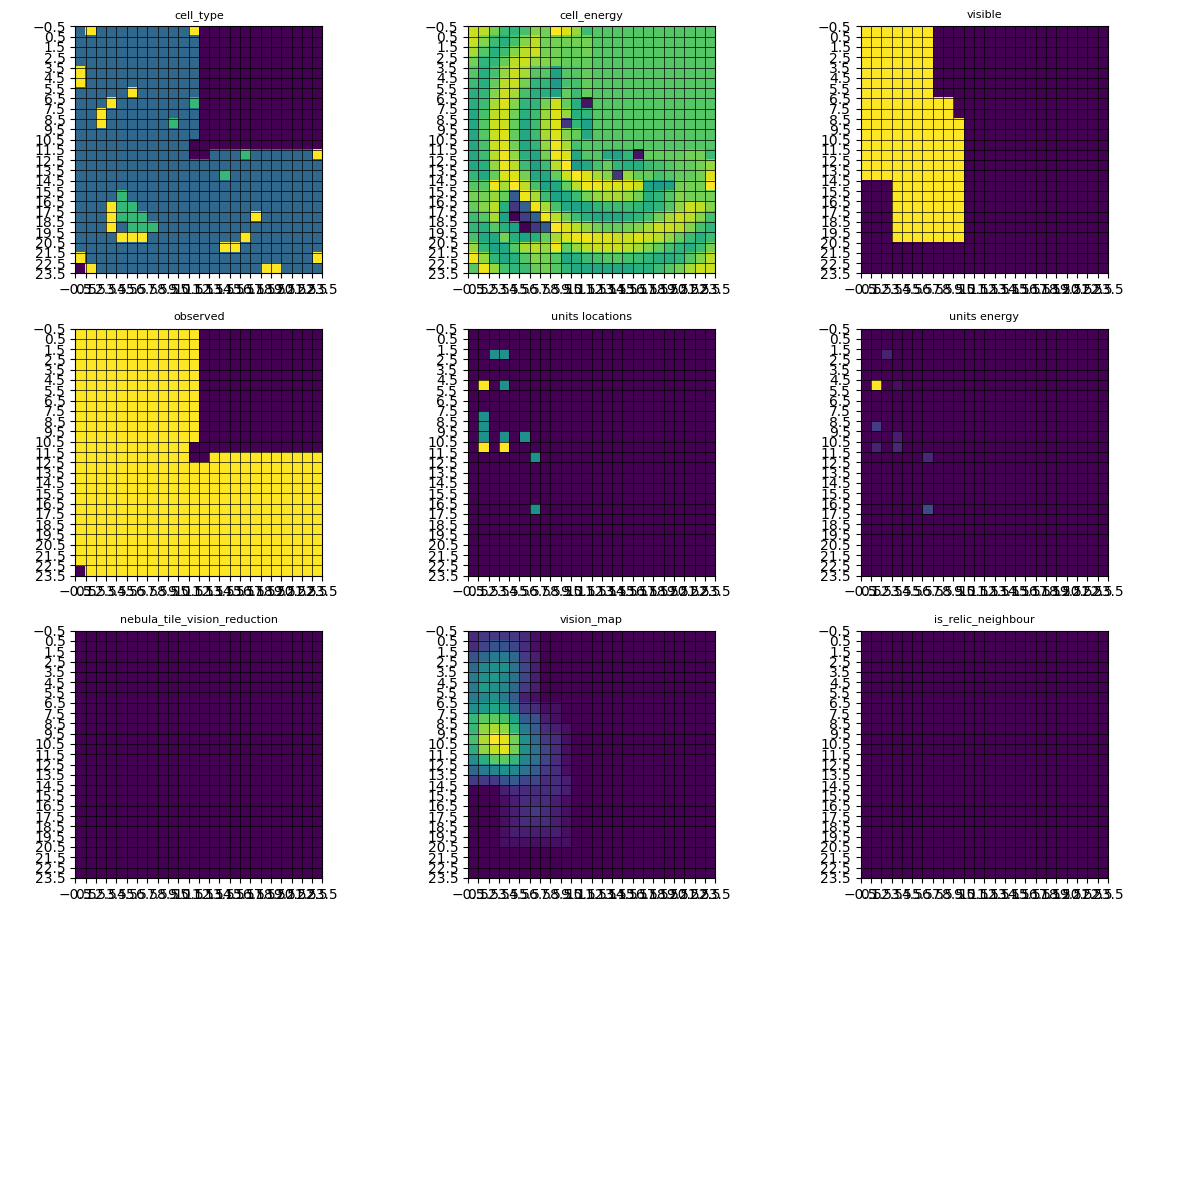

In [37]:
display(10)